In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import csv
from tqdm import tqdm
import torch.nn.functional as F
import os

In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"



In [50]:
base_path = r''

ids_path = 'prepeard_data2.csv'
vocab_path = "vocab.csv"

data_len = 2231142

In [51]:
with open(base_path + vocab_path, 'r') as file:
    vocab = [t[0] for t in list(csv.reader(file))[1:]]

print(vocab)

['<UKN>', '<PAD>', '.', '*', ',', 'and', 'the', '1', 'to', 'in', 'a', '2', 'with', '1/2', ')', '(', 'of', 'cup', 'until', 'add', 'for', 'or', 'c.', 'minutes', 'salt', 'sugar', 'into', 'on', 'pepper', 'heat', '3', 'teaspoon', 'butter', '1/4', 'chopped', 'oil', 'over', 'mix', 'cheese', 'water', ';', 'tsp', 'flour', 'large', 'cups', '4', 'cream', 'tablespoons', 'cook', 'pan', 'bowl', 'mixture', 'stir', 'about', 'onion', 'sauce', 'at', 'bake', 'baking', 'chicken', 'can', 'place', 'garlic', 'is', 'milk', 'tbsp', 'oven', 'it', 'medium', 'cut', 'top', 'eggs', 'brown', 'juice', 'ingredients', 'from', 'combine', 'pour', 'tablespoon', 'well', 'small', 'fresh', 'egg', 'remove', '5', 'serve', '8', 'then', 'vanilla', 'ground', 'cool', 'oz', 'powder', 'cover', '6', '12', 'you', 'each', 'all', '10', 'together', 'if', 'lemon', 'sliced', 'olive', '3/4', 'remaining', 'teaspoons', 'let', 'boil', 'set', 'lb', 'sprinkle', 'green', 'onions', ':', 'taste', 'are', 'hot', 'dough', 'as', 'red', 'ounces', 'tomat

In [52]:

vocab =  vocab + ["<ING>", "<REC>"]



w2id =  {w:i for i,w in  enumerate(vocab)}
id2w =  {i:w for i,w in  enumerate(vocab)}

(w2id)["<REC>"]

1501

In [53]:

    
class Generator_next_token(nn.Module):
    def __init__(self, vocab_len, hidden_size, num_layers=1):
        super(Generator_next_token, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_len, embedding_dim=hidden_size)
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(num_layers * hidden_size, vocab_len)

    def forward(self, input_sequence):
        embedded = self.embedding(input_sequence)
        # input_sequence shape: (batch_size, sequence_length, input_size)
        hidden_states, (h_n, _) = self.rnn(embedded)
        # h_n shape: (num_layers, batch_size, hidden_size)

        # Concatenate or stack hidden states from all layers
        h_n_flat = h_n.permute(1, 0, 2).contiguous().view(input_sequence.size(0), -1)
        
        # Pass through the linear layer

        output = self.fc(h_n_flat)
        # output shape: (batch_size, output_size)
       
        return output, hidden_states

# Example usage
batch_size = 32
sequence_length = 10
input_size = 5
hidden_size = 64
output_size = input_size

# Create an instance of the Generator
generator = Generator_next_token(input_size, hidden_size, 2)

# Generate a random batch of input sequences
input_sequence = torch.randint(0,input_size,(batch_size, sequence_length))

# Forward pass through the generator
output_vector, _ = generator(input_sequence)

print("Input sequence shape:", input_sequence.shape)
print("Output vector shape:", output_vector.shape)


Input sequence shape: torch.Size([32, 10])
Output vector shape: torch.Size([32, 5])


In [54]:


# Define the Generator
class Generator(nn.Module):
    def __init__(self, vocab_len,hidden_size, depth,max_len):
        super(Generator, self).__init__()
        
        self.embedding = nn.Linear(vocab_len, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers=depth, batch_first=True)
        self.hidden2vocab = nn.Linear(hidden_size, vocab_len)
        self.hidden_l = nn.Linear(hidden_size * depth, hidden_size)
        self.max_len = max_len
        

        
        

    def forward(self, input_seq):
        original_input = input_seq.clone()
        sequences = self.embedding(input_seq.float())
        outputs = []
    
        for _ in range(self.max_len):
            last_hidden, hidden_states = self.singel_pass(sequences)
            outputs.append(last_hidden)
            sequences = torch.cat((sequences, last_hidden.unsqueeze(1)), dim = 1)
       
        outputs = torch.stack(outputs, dim = 1)
        vocab_vectors = self.hidden2vocab(outputs)
        vocab_probs = torch.softmax(vocab_vectors, dim=2)
        
        out = torch.concat((original_input,vocab_probs), dim=1)
        return out, hidden_states
            
        

    def singel_pass(self, input_seq):
        rand_source = torch.rand((input_seq.shape[0], 1, input_seq.shape[2])).to(device)
        #embedded = torch.concat((rand_source, embedded), dim = 1)
        hidden_states, (last_hidden, _) = self.rnn(input_seq)
        last_hidden = last_hidden.view(1, -1)
        output = self.hidden_l(last_hidden)
        
        return output, hidden_states


# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, vocab_len, hidden_size):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_len, embedding_dim=hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, input):
        embedded = self.embedding(input)
        hidden_states, (last_hidden, _) = self.rnn(embedded)
        output = self.fc(last_hidden)
        prob = F.sigmoid(output)
        return prob, hidden_states

In [55]:
class CSVDataLoader:
    def __init__(self, csv_file_path, batch_size, num_rows, start = 0):
        self.csv_file_path = csv_file_path
        self.batch_size = batch_size
        self.num_rows = num_rows
        self.current_index = 0
        self.file_handle = None
        self.csv_writer = None
        self.headers = None

    def open_csv_file(self):
        self.file_handle = open(self.csv_file_path, 'r', newline='')
        self.csv_writer = csv.reader(self.file_handle)
        # Assuming the first row contains headers
        self.headers = next(self.csv_writer)

    def close_csv_file(self):
        if self.file_handle is not None and not self.file_handle.closed:
            self.file_handle.close()

    def reset(self):
        self.close_csv_file()
        self.open_csv_file()
        self.current_index = 0

    def has_next_batch(self):
        return self.current_index < self.num_rows

    def get_next_batch(self, pad):
        ing_batch = [] 
        rec_batch = []
        for _ in range(self.batch_size):
            if not self.has_next_batch():
                break
            ing, rec = next(self.csv_writer)
            ing_batch.append(torch.tensor(eval(ing)).to(device))
            rec_batch.append(torch.tensor(eval(rec)).to(device))
            self.current_index += 1
       
        

        ing_padded = pad_sequence(ing_batch, batch_first=True, padding_value=pad)
        rec_padded = pad_sequence(rec_batch, batch_first=True, padding_value=pad)
        return ing_padded, rec_padded
    
    def batches_left(self):
        return (self.num_rows - self.current_index) // self.batch_size
    
    def __del__(self):
        self.close_csv_file()

In [56]:
for i in range(1,100,10):
    print(F.normalize(torch.tensor([[0.1,0.2,0.5]], dtype=torch.float32) * i, dim = 1))

tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])
tensor([[0.1826, 0.3651, 0.9129]])


In [57]:
"""args = torch.randint(1,100, (1000, 3))
r = torch.arange(2500).view(50, -1)
for b,c,d in tqdm(args):
    h = one_hot_noisify_tokens(r, 2500, b,c,30).argmax(dim=2)
    assert(torch.equal(r, h))"""

'args = torch.randint(1,100, (1000, 3))\nr = torch.arange(2500).view(50, -1)\nfor b,c,d in tqdm(args):\n    h = one_hot_noisify_tokens(r, 2500, b,c,30).argmax(dim=2)\n    assert(torch.equal(r, h))'

In [58]:
def patch_batch(ings, start, midel):
    start_tokens = torch.full((ings.shape[0],), start).unsqueeze(1).to(device)
    midel_tokens = torch.full((ings.shape[0],), midel).unsqueeze(1).to(device)
    return torch.cat((start_tokens, ings, midel_tokens), dim=1).to(device)


In [59]:
data_path = r"prepeard_data2.csv"
data_loader = CSVDataLoader(data_path, 32, 2231142)
data_loader.open_csv_file()
d = data_loader.get_next_batch(w2id["<PAD>"])
data_loader.close_csv_file()

patch_batch(d[0], w2id["<ING>"], w2id["<REC>"])[0]

tensor([1500,    7,   80,  434,    0,  155,    4,   69,  142,    3,   45,    0,
          59,  472,    3,    7,   60,   46,   16,  436,  147,    3,    7, 1167,
         204,   46,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1, 1501], device='cuda:0')

In [60]:
class Dummy_loader:
    def __init__(self, d) -> None:
        self.d = d

    def reset(self):
        pass
    def open_csv_file(self):
        pass
    def batches_left(self):
        return 1

    def get_next_batch(self, a):
        return self.d
    

In [61]:
class NextTokenPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim,num_layers, dropout_rate):
        super(NextTokenPredictor, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, 
                    dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, vocab_size)

        self.init_hidden = nn.Parameter(torch.zeros(1, 1, hidden_dim), requires_grad=True)
      

    def forward(self, x):
       
        embedding = self.dropout(self.embedding(x))
        output, hidden = self.lstm(embedding)          
        output = self.dropout(output) 
        prediction = self.fc(output)
        return prediction

In [62]:
# Hyperparameters
generator_hidden_size = 3048
embed_size = 1500
generator_depth = 4
drop_rate = 0.8

gen_lr  = 0.001
batch_size = 8
epochs = 1

seq_len = 20

nr_batches = 200

test_size = 1000

In [63]:

#a = CSVDataLoader(r"C:\Users\mrmrk\OneDrive\Documents\GitHub\recipe_generation\dummy_data.csv", 1, 1)
#a.open_csv_file()
#pad1 = w2id["<PAD>"]

#dummy_loader = Dummy_loader(a.get_next_batch(pad1))
data_loader = CSVDataLoader(data_path, batch_size, data_len - test_size)


#data_loader = dummy_loader


data_loader.open_csv_file()
# Instantiate Generator and Discriminator
generator = NextTokenPredictor(len(vocab),embed_size, generator_hidden_size, generator_depth, drop_rate).to(device)



# Loss and Optimizer
criterion = nn.CrossEntropyLoss()

gen_optimizer = optim.Adam(generator.parameters(), lr=gen_lr)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(gen_optimizer,mode='min',factor=0.8, patience=3, threshold=0.00005)
max_grad_norm = 1.0
#torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_grad_norm)
#torch.nn.utils.clip_grad_norm_(generator.parameters(), max_grad_norm)


avg_gen_losses = []


if not os.path.exists("simpel_model.pth"):
    for epoch in (range(epochs)):
        
        data_loader.reset()
        batch_nr = 0
        total_nr_batches = data_loader.batches_left()
        #total_nr_batches =  100
        itr =(range(total_nr_batches))
        progress_bar = tqdm(total=nr_batches)
        for batch_nr in itr:
            if batch_nr == nr_batches:
                break
            
            # Training the Discriminator
            pad1 = w2id["<PAD>"]
        
    
            real_ingredients, real_recipies = data_loader.get_next_batch(pad1)
            real_patched_ings = patch_batch(real_ingredients, 
                                                w2id["<ING>"],
                                                w2id["<REC>"])
            
            #Generator input does not need to be smoothend
            real_batch = torch.concat((real_patched_ings,
                                        real_recipies), dim = 1)

        
            current_seq_len = min(seq_len,real_batch.shape[1])
            gen_losses = []
            for index in range(0,real_batch.shape[1]- seq_len - 1, seq_len):
                current_seq_len = min(current_seq_len, real_batch.shape[1]-index)
                #current_seq_len = seq_len
                gen_optimizer.zero_grad()
                sequence_x = real_batch[:, index:index+current_seq_len]   
                tokens_y = torch.nn.functional.one_hot(real_batch[:, index+1:index+current_seq_len+1]  , len(vocab))
                
                generated_logits = generator(sequence_x)
                
                gen_loss = criterion(generated_logits, tokens_y.float()) / current_seq_len
                gen_loss.backward()
                gen_optimizer.step()
                gen_losses.append(gen_loss.item())
            batch_avg_loss = sum(gen_losses) / len(gen_losses)
            lr_scheduler.step(batch_avg_loss)
            avg_gen_losses.append(batch_avg_loss)
            progress_bar.update(1)
    torch.save(generator.state_dict(), 'simpel_model.pth')
    torch.save(avg_gen_losses, 'simpel_model_losses.pth')
        

    
            

In [64]:
torch.cuda.empty_cache()
generator = NextTokenPredictor(len(vocab),embed_size, generator_hidden_size, generator_depth, drop_rate).to(device)
generator.load_state_dict(torch.load('simpel_model.pth'))
avg_gen_losses = torch.load('simpel_model_losses.pth')

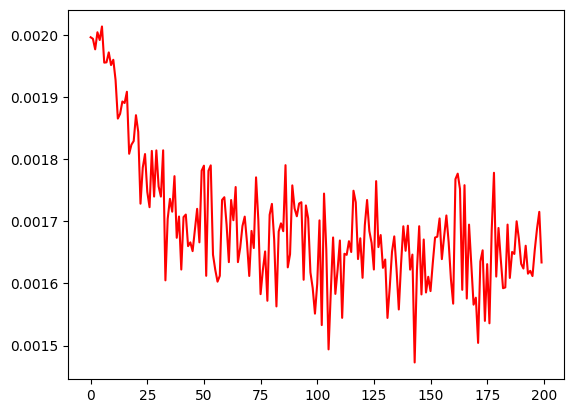

0.0018105789786204696

In [65]:
import matplotlib.pyplot as plt
plt.plot(avg_gen_losses, color = "red")
plt.show()
gen_losses[-1]

In [66]:
if not os.path.exists("perplexities.pth"):
    from torcheval.metrics.text import Perplexity
    test_batch_size = 1
    data_loader = CSVDataLoader(data_path, test_batch_size, data_len - test_size)
    data_loader.open_csv_file()
    perplexities = []
    with  tqdm(range(int(test_size / test_batch_size))) as itr:
        with torch.no_grad():
            metric=Perplexity().to(device)
            perplexities = []
            for i in itr:  # Use your validation data loader
                real_ingredients, real_recipies = data_loader.get_next_batch(w2id["<PAD>"])
                real_ingredients, real_recipies = real_ingredients.to(device), real_recipies.to(device)
                real_patched_ings = patch_batch(real_ingredients, 
                                                    w2id["<ING>"],
                                                    w2id["<REC>"])
                real = torch.concat((real_patched_ings,
                                            real_recipies), dim = 1).to(device)
                real_x = real[:,:-1]
                real_y = real[:,1:].to(device)
                outputs = generator(real_x).to(device)
                #print(outputs.shape, real_y.shape)
                metric.update(outputs, real_y)
                perplexity = metric.compute()
                perplexities.append(perplexity.item())
                # calculating perplexity    

perplexities = torch.load("perplexities.pth")
sum(perplexities) / len(perplexities)

475.9781254483984

In [67]:
from nltk.tokenize import word_tokenize

In [68]:
def encode(prompt, dic):
    return [dic.get(t.lower(),dic["<UKN>"]) for t in word_tokenize(prompt)]

In [69]:
encode("1. break milk I brew a cool candy", w2id)

[0, 733, 64, 209, 0, 10, 90, 855]

In [70]:
def decode(answer, dic):
    return " ".join([dic[i] for i in answer])

In [71]:
decode(encode("we bake a NLP cake", w2id), id2w)

'we bake a <UKN> cake'

In [72]:
def topk(next_logits, k):
    next_probs = torch.softmax(next_logits, dim=1)
    topk_values, topk_indices = torch.topk(next_probs, k, dim=1)
    topk_values, topk_indices = topk_values.to(device), topk_indices.to(device)
    topk_index_indices = torch.multinomial((topk_values), 1).squeeze(1).to(device)
    next_tokens = topk_indices[
        torch.arange(topk_index_indices.shape[0]), topk_index_indices]
    return next_tokens

In [73]:
def generate(prompt, generator, gen_len, strat):
    t = torch.tensor(encode(prompt, w2id)).unsqueeze(0).to(device)
    batch = (patch_batch(t,
                                w2id["<ING>"],
                                w2id["<REC>"]))
    for _ in range(gen_len):
        answer = generator(batch)[:,-1, :]
        valid_choices = answer[:,1:-2]
        new_token = strat(valid_choices) + 1
        if id2w[new_token.item()] == "<PAD>":
            break
        batch = torch.concat((batch, new_token.unsqueeze(1)), dim = 1)
        

    return decode([i.item() for i in batch[0]], id2w)

In [74]:
decode([31, 140, 208, 16], id2w)

'teaspoon drain will of'

In [75]:
print(list(w2id.keys())[-100:-1])

['cm', 'pancakes', 'air', 'oyster', 'maraschino', 'cashews', 'butterscotch', 'toppings', 'finished', 'crisp-tender', 'pepperoni', 'browns', 'flame', 'seedless', 'dinner', 'saffron', 'chunky', 'pam', 'relish', '6-8', 'flat-leaf', 'bath', 'miracle', 'pimento', 'unpeeled', 'grnd', 'scatter', '450Â°', 't.', 'stewed', 'weed', 'wild', 'release', 'cupcake', 'pale', 'turns', 'skinned', 'walnut', 'scallion', 'starch', 'reduced-fat', 'week', 'strip', 'browning', 'loin', 'works', 'drink', 'kernel', 'diagonally', '375f', 'calories', 'bite-size', '...', 'popcorn', 'test', 'could', 'limes', '-4', 'philadelphia', 'barley', 'sprinkling', 'bourbon', 'hrs', 'find', 'and/or', 'organic', 'undiluted', '10-12', 'dollop', 'pureed', 'wipe', 'sauerkraut', 'bulk', 'rim', 'briefly', 'polenta', 'burgers', 'hazelnuts', 'pop', 'baguette', '400f', 'nicely', 'circles', 'mussels', 'ovenproof', 'pancetta', 'pipe', 'low-sodium', '1-1/4', 'tie', '400Â°f', 'sear', 'pressed', '55', 'shelled', 'simple', 'whatever', 'crusty'

In [76]:
seed = 1337
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
ing, rec = "1 tsp. olive oil * 1 1/2 lb. skinless, boneless chicken-breat halves * 1/2 tsp. dried oregano * salt and pepper * 1/4 c. tahini * 1/4 c. water * 3 tbsp. nonfat plain yogurt * 1 tbsp. fresh lemon juice * 1 clove garlic * 1/4 c. Cilantro leaves * 1/4 tsp. ground red pepper (cayenne) * 4 pitas * 2 c. romaine lettuce * 1/2 seedless cucumber * 1 large tomato * 2 green onions","In 12-inch nonstick skillet, heat oil 1 minute on medium. Sprinkle chicken with oregano, 1/4 teaspoon salt, and 1/4 teaspoon freshly ground black pepper, and toss to coat. Add chicken to skillet and cook 5 to 7 minutes or until chicken is no longer pink throughout. Transfer chicken to plate or bowl; cover with foil to keep warm. Meanwhile, make tahini sauce: In small bowl, with wire whisk, combine tahini, water, yogurt, lemon juice, and garlic. Stir in cilantro, ground red pepper, 1/4 teaspoon salt, and 1/4 teaspoon freshly ground black pepper. Makes about 3/4 cup tahini sauce. To serve, cut off one-fourth of each pita and save for use another day. Carefully open each pita pocket and fill with one-fourth each romaine, cucumber, tomato, chicken, and green onions. Top with tahini sauce; serve gyros with any additional sauce on the side."

generator.eval()
with torch.no_grad():
    for i in range(5):
        print(((generate("Banana", generator, 100, lambda p: topk(p,8))).split("<REC>")[1]))
print()
print(rec)

 sugar , pour and stir * 3 tsp . add with * 1 minutes minutes and chopped . bake with all 350Â° 1/2 x minutes minutes * 1 minutes , remove powder crispy and bake . bake into a tsp x minutes or ) . bake into dash minutes minutes or and remove in 1 tbsp . vanilla can bake * 1 tsp c. remove , add with * 3 c. add sugar and place at 1/4 lb c. bake juice . remove with , pour * 1/2 tsp . add beef and bake in 1 c. stir and chopped
 chopped and bake 1 1 tsp c. remove sauce , pour at 1 tbsp hours . sprinkle juice and sprinkle into 2 lb . pour into 350Â° tsp . add into a for 2 tsp . add beef * 1 c. sugar sauce , add at 350Â° 1 1/2 minutes minutes pan . pour at 350Â° 1/4 1/4 minutes . let can pour and drained into dash 1/2 3 c. stir cheese , pour and sprinkle at 1 tsp lb . place pkg . bake with and pour into 4 for 2 minutes . pour can bake cheese * 2
 grated powder and bake in 1/2 c. stir powder * 2 c. add powder and sprinkle at . stir can sugar and stir over . bake into a medium minutes oz 1/2 mi